# Imports

In [2]:
import os
from random import randint
import uuid
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import yaml
from munch import Munch
import random
import copy
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
import math

from eval import get_run_metrics
from tasks import get_task_sampler
from samplers import get_data_sampler
from models import build_model

import torch.nn as nn
import torch.optim as optim


from hook_model import hook_model, search_heads_get_loss, get_model, get_data, get_acts, PassThroughEmbed 

from fancy_einsum import einsum                                                                                                                                                                   
import torch
import numpy as np
import pandas as pd
from torch import nn
import wandb
from jaxtyping import Float
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilitie
import einops

import transformer_lens.utils as utils
import plotly.express as px
from samplers import get_data_sampler
from tasks import get_task_sampler
from eval import get_model_from_run, get_run_metrics
torch.backends.cudnn.benchmark = True

import logging

def get_model(path, device="cpu"):
    class PassThroughEmbed(nn.Module):
        def __init__(self, cfg=None):
            super().__init__()
            # No parameters needed, but constructor accepts cfg for compatibility

        def forward(self, tokens):
            # Directly return the input without any modifications
            return tokens

    model = torch.load(path, map_location=device)
    tl_model = model.to(device)
    tl_model.set_use_attn_result(True)
    tl_model.set_use_split_qkv_input(True)
    if "use_hook_mlp_in" in tl_model.cfg.to_dict():
        tl_model.set_use_hook_mlp_in(True)
    return tl_model

device = torch.device('cpu')
# Set the logging level to ERROR to ignore warnings
logging.getLogger().setLevel(logging.ERROR)

def validation_metric(predictions, labels, return_one_element, device):
    predictions = predictions.to(device)

    # loss is mse on last 5 predictions (full context)
    loss = (labels.to(device) - predictions.to(device)).square().cpu().numpy().mean(axis=0)[-5:].mean()
    return loss

def straight_loss(predictions, labels, device):
    predictions = predictions.to(device)

    # loss is mse on last 5 predictions (full context)
    loss = (labels.to(device) - predictions.to(device)).square().cpu().numpy().mean(axis=0).mean()
    return loss

def plot_loss(pred, labels, conf, device):

    loss = (labels.to(device) - pred.to(device)).square().cpu().numpy()

    baseline = {
        "linear_regression": conf.model.n_dims,
    }[conf.training.task]

    plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
    plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")
    plt.legend()
    plt.show()

def test_model(device, conf, model, read_in_weight, read_in_bias, graph=False):
    input, _, labels, _ = get_data(conf, read_in_weight, read_in_bias)

    with torch.no_grad():
        my_pred = model(input)[:, ::2, 0][:, torch.arange(labels.shape[1])].cpu() # this last transformation before returning is in the original and I assume only selects the predictions for ys
    
    mse_on_last_5 = validation_metric(my_pred, labels, True, device)
    total_loss = straight_loss(my_pred, labels, device)

    if graph:
        plot_loss(my_pred, labels, conf, device)

    return mse_on_last_5, total_loss

def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def index_to_original(index, d_model, position, layers=3):
    size_per_layer = d_model * position
    layer = index // size_per_layer
    index_within_layer = index % size_per_layer
    pos = index_within_layer // d_model
    dim = index_within_layer % d_model
    return layer % layers, pos, dim

def compute_loss_with_replacement(base_activations, corrupt_activations, probe, loss_func, weights, index):

    modified_activations = base_activations.clone()  # Clone to avoid modifying the original tensor
    modified_activations[:, index] = corrupt_activations[:, index]  # Replace the specified dimension
    
    # Compute the output and loss with the modified activations
    output = probe(modified_activations)
    return loss_func(output, weights.squeeze(-1)).item()

def project_eigenvector_torch(eig_input, eig_vector):
    eig_vector_norm = eig_vector / eig_vector.norm()
    projections = torch.matmul(eig_input, eig_vector_norm)
    return projections


/Users/marcomolinari/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The model
embedding is done manually as changing HookedTransformer's embedding with transformer_lens proved tricky.

In [5]:
config_path = "config.yaml"
with open(config_path) as fp:
    conf = Munch.fromDict(yaml.safe_load(fp))
model = get_model('./weights/state.pt', device)
read_in_weight = torch.load('./weights/read_in_weight.pt', map_location=device)
read_in_bias = torch.load('./weights/read_in_bias.pt', map_location=device)

Moving model to device:  cpu


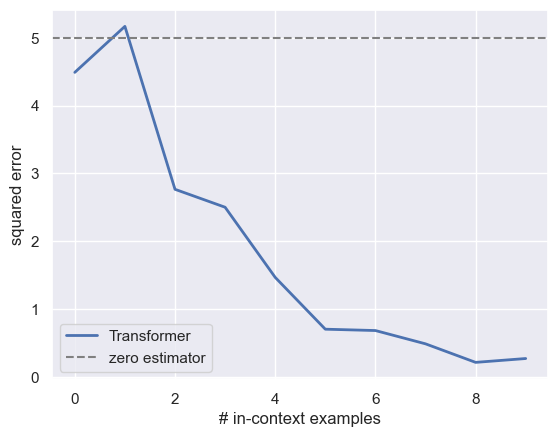

'loss on last 5 points, and on whole sequence: (0.47495836, 1.8767551)'

In [6]:
'loss on last 5 points, and on whole sequence: ' + str(test_model(device, conf, model, read_in_weight, read_in_bias, True))

# Computational Graph

ACDC not run here, but at: https://github.com/FlexCode29/LSE-AI-ACDC

# Probing

In [4]:
in_features = 64 * 64 * 3 
out_features = 5 

probe = nn.Linear(in_features=in_features, out_features=out_features)
state = torch.load("./probe_state.pt", map_location=torch.device('cpu'))

probe.load_state_dict(state["model_state_dict"])

<All keys matched successfully>

In [20]:
loss_func= nn.MSELoss()

probe_input, _, probe_ys, probe_weights = get_data(conf, read_in_weight, read_in_bias)
_, probe_cache = model.run_with_cache(probe_input)

mlp_activations = get_acts(probe_cache)
probe_output = probe(mlp_activations)

loss = loss_func(probe_output, probe_weights.squeeze(-1))

corrupt_probe_input, _, _, corrupt_probe_weights = get_data(conf, read_in_weight, read_in_bias)

_, corrupt_probe_cache = model.run_with_cache(corrupt_probe_input)

corrupt_mlp_activations = get_acts(corrupt_probe_cache)

In [21]:
base_loss = loss_func(probe_output, probe_weights.squeeze(-1)).item()
base_loss

0.3786950409412384

In [22]:
# Initial setup
d_model = position = conf.model.n_embd  # Dimensionality of the model
layers = conf.model.n_layer

num_dimensions = d_model * position * 3  # Total dimensions for 3 MLPs
loss_differences = np.zeros(num_dimensions)

# Iterate over each dimension and compute the loss difference
for i in tqdm(range(num_dimensions)):
    loss_differences[i] = compute_loss_with_replacement(mlp_activations, corrupt_mlp_activations, probe, loss_func, probe_weights, i) - base_loss

100%|██████████| 12288/12288 [00:07<00:00, 1715.14it/s]


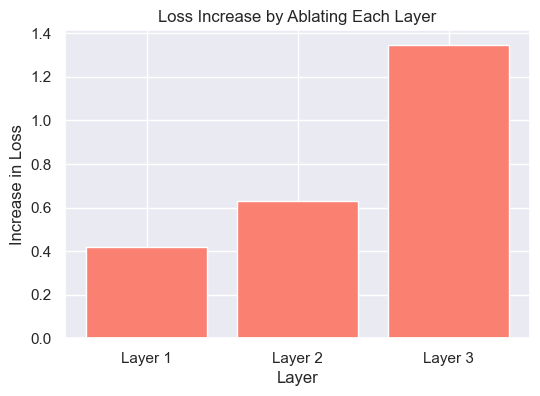

In [23]:
layer_loss_increments = np.zeros(layers)  # There are 3 layers

for layer in range(layers):
    modified_activations = mlp_activations.clone()
    
    # Calculate the start and end indices for this layer
    start_index = layer * d_model * position
    end_index = start_index + d_model * position
    
    # Ablate the entire layer
    modified_activations[:, start_index:end_index] = corrupt_mlp_activations[:, start_index:end_index]
    
    current_output = probe(modified_activations)
    layer_loss_increments[layer] = loss_func(current_output, probe_weights.squeeze(-1)).item() - base_loss

# Plotting the loss increase by ablating each layer
plt.figure(figsize=(6, 4))
plt.bar(['Layer 1', 'Layer 2', 'Layer 3'], layer_loss_increments, color='salmon')
plt.title('Loss Increase by Ablating Each Layer')
plt.xlabel('Layer')
plt.ylabel('Increase in Loss')
plt.show()

# Embedding analysis

In [24]:
clean_input, clean_xs, clean_ys, _ = get_data(conf, read_in_weight, read_in_bias)
clean_output, clean_cache = model.run_with_cache(clean_input)
clean_output = clean_output[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()  

corrupt_input, corrupt_xs, corrupt_ys, _ = get_data(conf, read_in_weight, read_in_bias)
corrupt_output, corrupt_cache = model.run_with_cache(corrupt_input)
corrupt_output = corrupt_output[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()

In [25]:
def xs_attn0_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = False

    if patch_ys:
        resid_pre[:, 1::2, 0, :] = resid_pre[:, 1::2, 0, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, 0, :] = resid_pre[:, ::2, 0, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre
    
def ys_attn0_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = True

    if patch_ys:
        resid_pre[:, 1::2, 0, :] = resid_pre[:, 1::2, 0, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, 0, :] = resid_pre[:, ::2, 0, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre

def xs_attn1_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = False

    if patch_ys:
        resid_pre[:, 1::2, 1, :] = resid_pre[:, 1::2, 1, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, 1, :] = resid_pre[:, ::2, 1, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre
    
def ys_attn1_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = True

    if patch_ys:
        resid_pre[:, 1::2, 1, :] = resid_pre[:, 1::2, 1, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, 1, :] = resid_pre[:, ::2, 1, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre

def xs_residual_stream_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = False

    if patch_ys:
        resid_pre[:, 1::2, :] = resid_pre[:, 1::2, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, :] = resid_pre[:, ::2, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre

def ys_residual_stream_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = True

    if patch_ys:
        resid_pre[:, 1::2, :] = resid_pre[:, 1::2, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, :] = resid_pre[:, ::2, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre

In [26]:
xs_ys_embed_expriment = pd.DataFrame(columns=['Activation', 'Ablating (xs/ys)', 'Ablated Loss'])
activations_using_embedding = ['blocks.0.hook_q_input', 'blocks.0.hook_k_input', 'blocks.0.hook_v_input', 'blocks.0.hook_mlp_in', 'blocks.1.hook_q_input', 'blocks.1.hook_k_input', 'blocks.1.hook_v_input', 'blocks.1.hook_mlp_in', 'blocks.2.hook_q_input', 'blocks.2.hook_k_input', 'blocks.2.hook_v_input', 'blocks.2.hook_mlp_in']

In [27]:
with torch.no_grad():
    for activation in activations_using_embedding:
        model.reset_hooks()

        if activation.split('.')[2] == 'hook_mlp_in':
            # we're using mlp

            xs_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), xs_residual_stream_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            xs_ablated_loss = validation_metric(xs_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()

            ys_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), ys_residual_stream_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            ys_ablated_loss = validation_metric(ys_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()

            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation, 'Ablating (xs/ys)': 'xs', 'Ablated Loss': xs_ablated_loss}
            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation, 'Ablating (xs/ys)': 'ys', 'Ablated Loss': ys_ablated_loss}
        else:
            # using attn

            # head 0
            # xs
            
            head_0_xs_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), xs_attn0_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            head_0_xs_ablated_loss = validation_metric(head_0_xs_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()

            # ys
            head_0_ys_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), ys_attn0_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            head_0_ys_ablated_loss = validation_metric(head_0_ys_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()

            # head 1
            # xs
            head_1_xs_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), xs_attn1_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            head_1_xs_ablated_loss = validation_metric(head_1_xs_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()
            
            # ys
            head_1_ys_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), ys_attn1_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            head_1_ys_ablated_loss = validation_metric(head_1_ys_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()

            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation + '_head_0', 'Ablating (xs/ys)': 'xs', 'Ablated Loss': head_0_xs_ablated_loss}
            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation + '_head_0', 'Ablating (xs/ys)': 'ys', 'Ablated Loss': head_0_ys_ablated_loss}

            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation + '_head_1', 'Ablating (xs/ys)': 'xs', 'Ablated Loss': head_1_xs_ablated_loss}
            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation + '_head_1', 'Ablating (xs/ys)': 'ys', 'Ablated Loss': head_1_ys_ablated_loss}


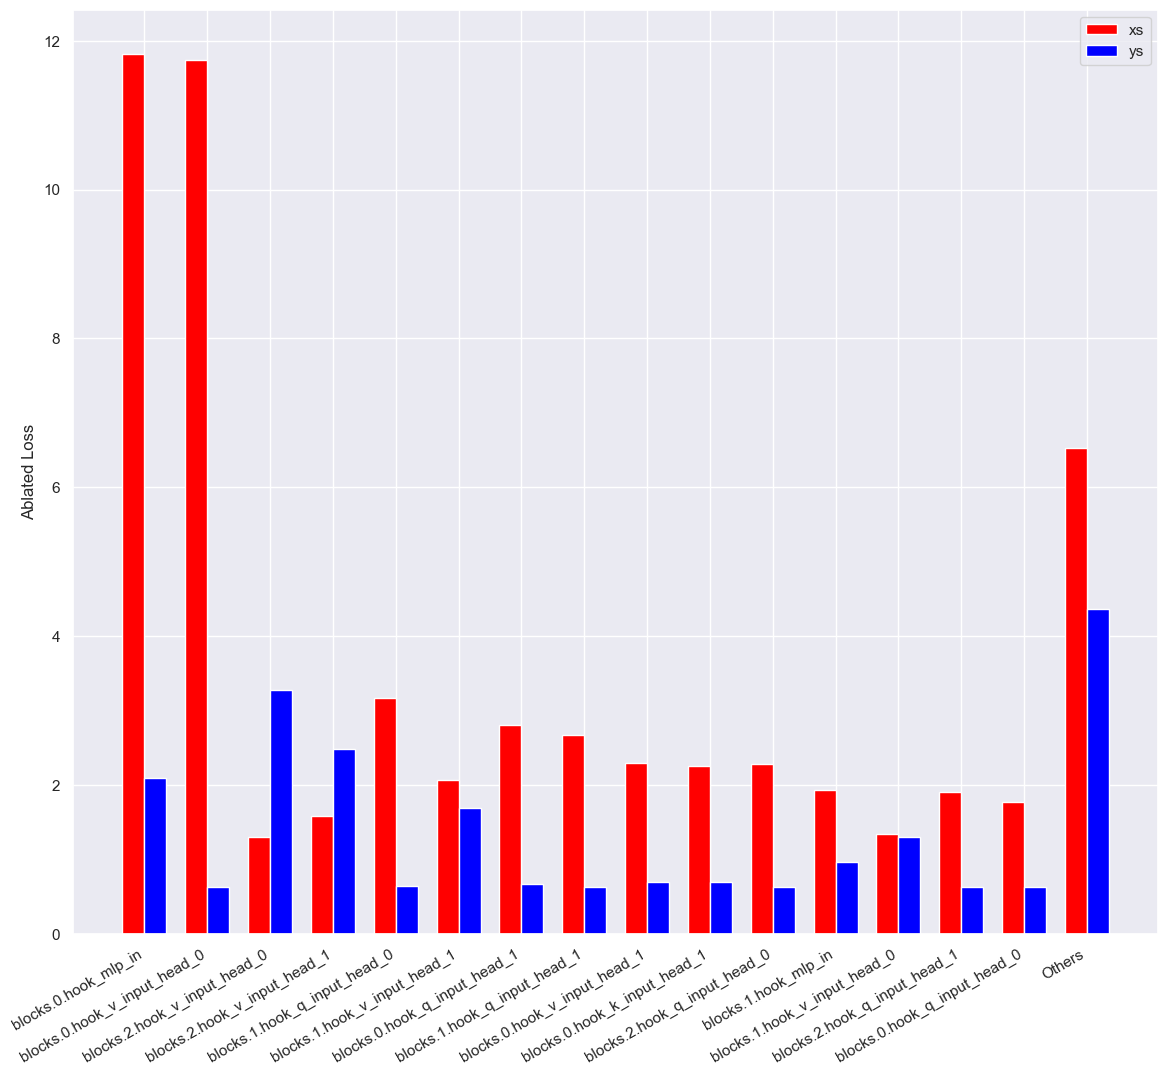

In [28]:
width = 0.35
top_n = 15

xs_ys_embed_expriment['Total Ablated Loss'] = xs_ys_embed_expriment.groupby(['Activation', 'Ablating (xs/ys)'])['Ablated Loss'].transform('sum')

# Then, create a pivot table to separate 'xs' and 'ys' losses for each activation
pivot_df = xs_ys_embed_expriment.pivot_table(index='Activation', columns='Ablating (xs/ys)', values='Total Ablated Loss', aggfunc='first')

# Calculate the sum of ablated losses (xs + ys) for sorting purposes
pivot_df['Sum Loss'] = pivot_df.sum(axis=1)

# Sort by 'Sum Loss' in descending order
sorted_pivot_df = pivot_df.sort_values(by='Sum Loss', ascending=False)

# Keep the top 20 activations and merge others into 'Others' category
top_n_pivot_df = sorted_pivot_df.iloc[:top_n, :2]
others_df = pd.DataFrame(sorted_pivot_df.iloc[top_n:, :2].sum()).transpose()
others_df.index = ['Others']

# Combine the top 10 activations dataframe and the "Others" dataframe for plotting
plot_df_with_others = pd.concat([top_n_pivot_df, others_df])

# Adjust positions for the updated number of categories
positions_with_others = range(len(plot_df_with_others))

fig, ax = plt.subplots(figsize=(14, 12))

# Plot vertical bars for xs and ys side by side, including 'Others'
ax.bar([p - width/2 for p in positions_with_others], plot_df_with_others['xs'], width, color='red', label='xs')
ax.bar([p + width/2 for p in positions_with_others], plot_df_with_others['ys'], width, color='blue', label='ys')

ax.set_ylabel('Ablated Loss')
# ax.set_title('Top Activations Plus Others by Ablated Loss for xs and ys')
ax.set_xticks(positions_with_others)
ax.set_xticklabels(plot_df_with_others.index, rotation=30, ha="right")
ax.legend(loc='upper right')


plt.show()

# Norm head analysis

Load the dataset with patched predictions, generated with the file https://github.com/FlexCode29/icl-mech-interp/blob/main/generate_patch_dataset.ipynb

In [29]:
df = pd.read_csv('a_0_0_patch_dataset.txt', sep=' ', header=None, names=['x1', 'x2', 'x3', 'y'])

Correlations and p values

In [30]:
x1_correlation, x1_p_value = pearsonr(df['x1'], df['y'])
x1_correlation, x1_p_value

(-0.8591959247715821, 0.0)

In [31]:
x2_correlation, x2_p_value = pearsonr(df['x2'], df['y'])
x2_correlation, x2_p_value

(-0.30171180917339524, 2.284808687413722e-282)

In [32]:
x3_correlation, x3_p_value = pearsonr(df['x3'], df['y'])
x3_correlation, x3_p_value

(-0.2057891986722223, 3.775269839175843e-129)

Plot x1

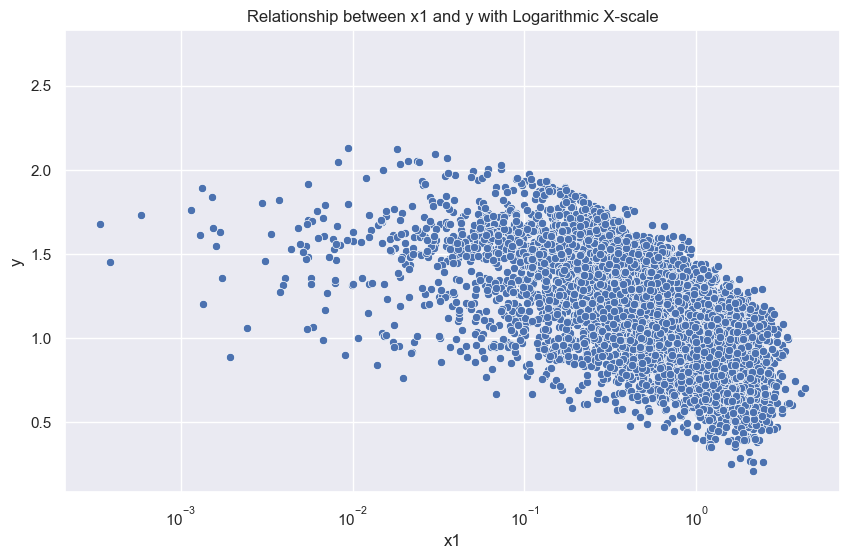

In [33]:
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
sns.scatterplot(data=df, x='x1', y='y')
plt.xscale('log')  # Set the x-axis to a logarithmic scale
plt.title(f'Relationship between x1 and y with Logarithmic X-scale')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

Load dataset with x1 = x2 = x3

In [34]:
oneD_df = pd.read_csv('1D_a_0_0_patch_dataset.txt', sep=' ', header=None, names=['x1', 'x2', 'x3', 'y'])

In [35]:
x_correlation, x_p_value = pearsonr(oneD_df['x1'], oneD_df['y'])
x_correlation, x_p_value

(-0.883586379864995, 0.0)

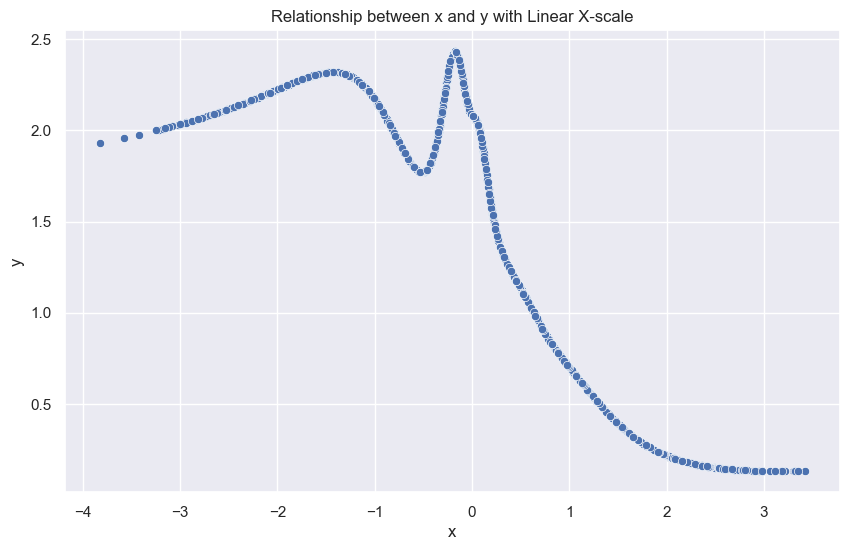

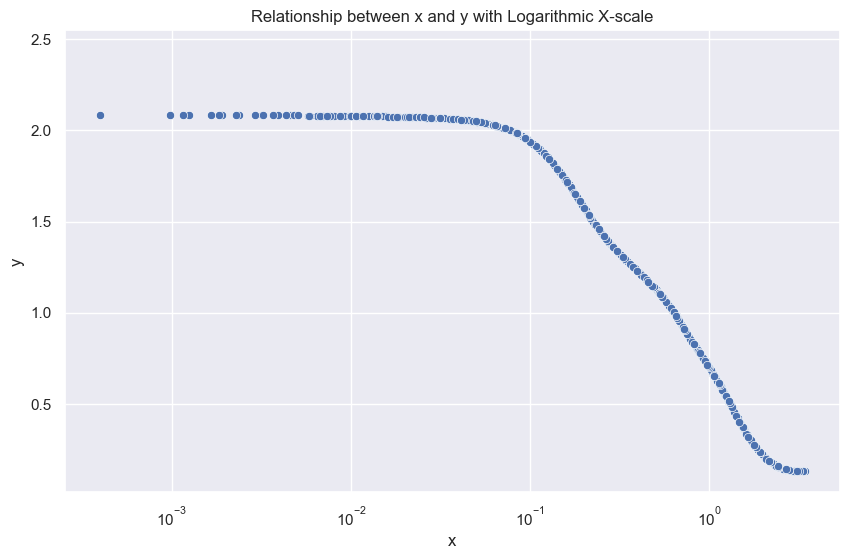

In [36]:
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
sns.scatterplot(data=oneD_df, x='x1', y='y')
#plt.xscale('log')  # Set the x-axis to a logarithmic scale
plt.title(f'Relationship between x and y with Linear X-scale')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
sns.scatterplot(data=oneD_df, x='x1', y='y')
plt.xscale('log')  # Set the x-axis to a logarithmic scale
plt.title(f'Relationship between x and y with Logarithmic X-scale')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Attention pattern

In [11]:
eig_input, eig_xs, eig_ys, w = get_data(conf, read_in_weight, read_in_bias)
_, eig_cache = model.run_with_cache(eig_input)

eig_attn = eig_cache['blocks.0.attn.hook_attn_scores'][0, 0][:20, :20].cpu()
eig_attn = eig_attn / math.sqrt(conf.model.n_embd / conf.model.n_head)
eig_attn = eig_attn.softmax(dim=-1)

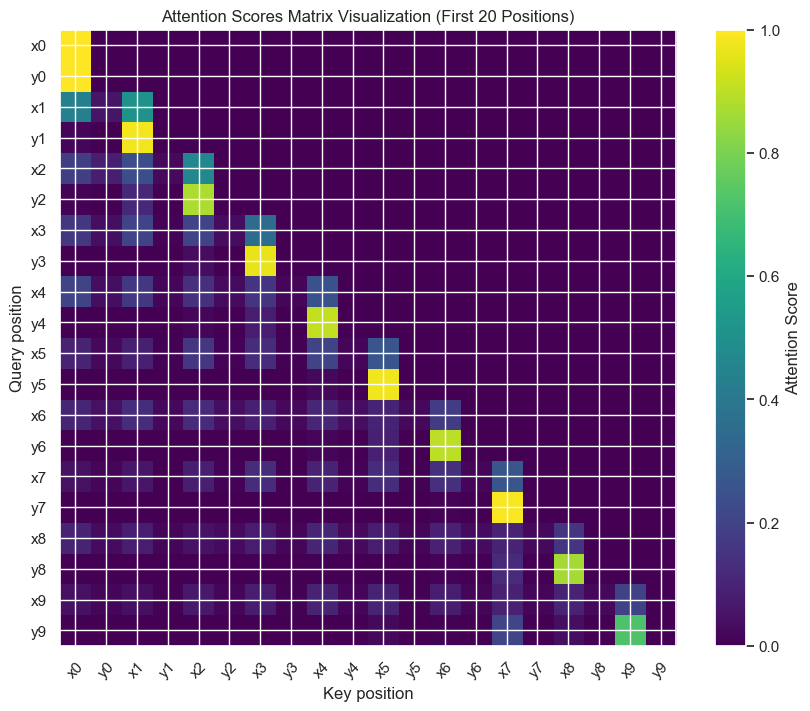

In [38]:
axis_labels = [f'x{i//2}' if i % 2 == 0 else f'y{i//2}' for i in range(20)]

plt.figure(figsize=(10, 8))
plt.imshow(eig_attn, cmap='viridis')
plt.colorbar(label='Attention Score')
plt.title('Attention Scores Matrix Visualization (First 20 Positions)')
plt.xlabel('Key position')
plt.ylabel('Query position')

plt.xticks(range(20), labels=axis_labels, rotation=45) 
plt.yticks(range(20), labels=axis_labels)

plt.show()

# Eigenvalues

In [8]:
OV_circuit_all_heads = model.OV
O = model.blocks[0].attn.W_O[0]
V = model.blocks[0].attn.W_V[0]
OV = torch.matmul(O, V)

eigvalues = torch.linalg.eig(OV_circuit_all_heads.AB[0, 0].cpu()).eigenvalues.to(torch.float32).to('cpu')

/var/folders/n9/zhld7qf57kddq5mvn4s7sxsw0000gn/T/ipykernel_27607/3213854995.py:6: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:301.)
  eigvalues = torch.linalg.eig(OV_circuit_all_heads.AB[0, 0].cpu()).eigenvalues.to(torch.float32).to('cpu')


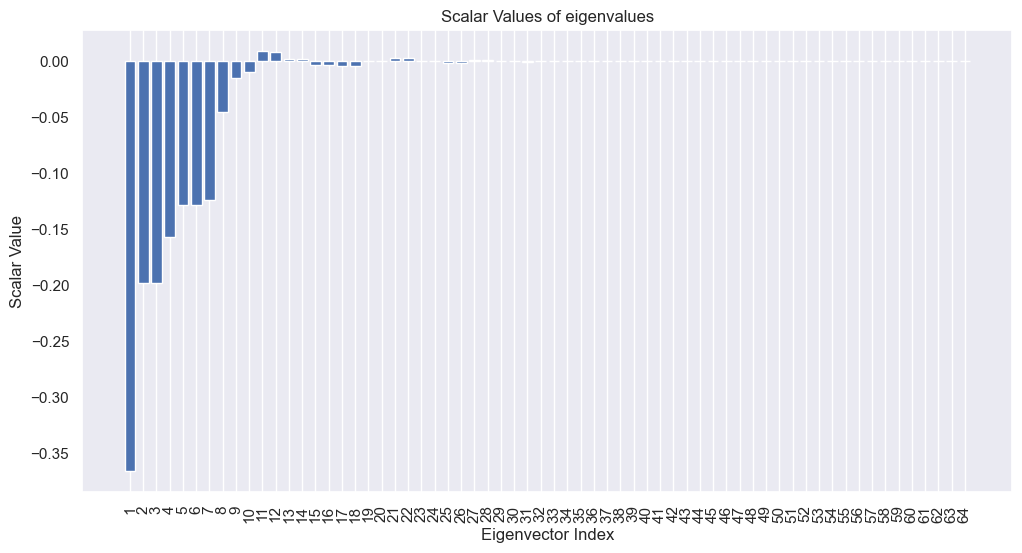

In [40]:
plt.figure(figsize=(12, 6))
plt.bar(range(1, 65), eigvalues.detach())
plt.title('Scalar Values of eigenvalues')
plt.xlabel('Eigenvector Index')
plt.ylabel('Scalar Value')
plt.xticks(range(1, 65), rotation=90)  # Adjusting x-axis labels for clarity
plt.grid(axis='y')
plt.show()

# Projections on principal eigenvector

In [9]:
n_features = 64
n_sequences = 10
n_points = 10

eigenvector = torch.linalg.eig(OV_circuit_all_heads.AB[0, 0].cpu()).eigenvectors.to(torch.float32).to('cpu')[0]

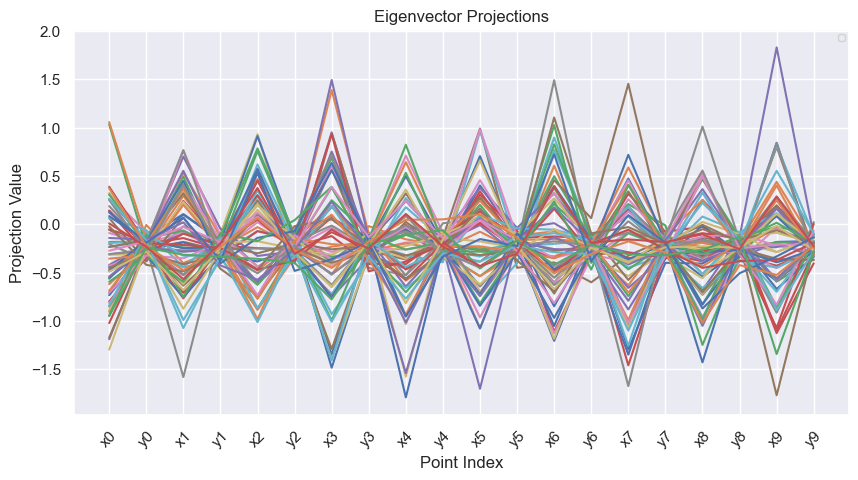

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

# Generating projections
projections = torch.stack([project_eigenvector_torch(eig_input[seq].cpu(), eigenvector.cpu()) for seq in range(eig_input.shape[0])])

# Plotting each sequence on the same axes
for seq in range(eig_input.shape[0]):
    ax.plot(range(0, n_points * 2), projections[seq, :(n_points * 2)].detach().numpy())

# Setting title, labels, and ticks
ax.set_title(f'Eigenvector Projections')
ax.set_xlabel('Point Index')
ax.set_ylabel('Projection Value')
axis_labels = [f'x{i//2}' if i % 2 == 0 else f'y{i//2}' for i in range(0, n_points * 2)]
ax.set_xticks(range(n_points * 2))
ax.set_xticklabels(axis_labels, rotation=45)  # Rotation for better readability

# Including a legend to identify each sequence
ax.legend(loc='upper right', prop={'size': 6}, ncol=2)

plt.show()

# Norm scores
computed in https://github.com/FlexCode29/icl-mech-interp/blob/main/hook_model.py

In [43]:
_, _, _, total_scores = search_heads_get_loss(model, conf, read_in_weight, read_in_bias)
norm_scores = total_scores.detach().numpy()

In [44]:
imshow(total_scores, xaxis="Head", yaxis="Layer", title="Norm Score for each head", zmax=1.0, zmin=0)

# Induction and copy heads

In [45]:
induction_score_store = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)
def induction_score_hook(
    pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    # We take the diagonal of attention paid from each destination position to source positions seq_len-1 tokens back
    # (This only has entries for tokens with index>=seq_len)
    induction_stripe = pattern.diagonal(dim1=-2, dim2=-1, offset=1-64)
    # Get an average score per head
    induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
    # Store the result.
    induction_score_store[hook.layer(), :] = induction_score

# We make a boolean filter on activation names, that's true only on attention pattern names.
pattern_hook_names_filter = lambda name: name.endswith("pattern")

model.run_with_hooks(
    clean_input, 
    return_type=None, # For efficiency, we don't need to calculate the logits
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

imshow(induction_score_store, xaxis="Head", yaxis="Layer", title="Induction Score by Head", zmax=1.0, zmin=-1.0)
'Average Induction score: ' + str(induction_score_store.mean().item())

'Average Induction score: 0.016952307894825935'

In [46]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

OV_circuit_all_heads = model.OV
OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues 

OV_copying_score = OV_circuit_all_heads_eigenvalues.sum(dim=-1).real / OV_circuit_all_heads_eigenvalues.abs().sum(dim=-1)
imshow(utils.to_numpy(OV_copying_score), xaxis="Head", yaxis="Layer", title="OV Copying Score for each head in fully trained model", zmax=1.0, zmin=-1.0)

# Phase transitions

In [58]:
before_path = './weights_before/' # at epoch 71k

before_model, before_conf = get_model_from_run(before_path)

before_model, before_read_in_weights, before_read_in_bias = hook_model(before_model, before_conf)
test_model(device, before_conf, before_model, before_read_in_weights, before_read_in_bias)

(14.016809, 15.178778)

In [59]:
after_path = './weights_after/' # at epoch 78k

after_model, after_conf = get_model_from_run(after_path)

after_model, after_read_in_weights, after_read_in_bias = hook_model(after_model, after_conf)
last_5_loss, whole_seq_loss = test_model(device, after_conf, after_model, after_read_in_weights, after_read_in_bias)
last_5_loss, whole_seq_loss

(8.453473, 11.419689)

Running the experiment will take a while because set batch_size at 512 for confidence

In [60]:
def move_annt_weights(model, after_model, layer, head):
    # model.W_K[layer, head, :, :] = after_model.W_K[layer, head, :, :]
    W_K_clone = model.blocks[layer].attn.W_K.clone()
    new_tensor = after_model.blocks[layer].attn.W_K[head].clone()
    W_K_clone[head] = new_tensor
    model.blocks[layer].attn.W_K.copy_(W_K_clone)
    
    #model.W_O[layer, head, :, :] = after_model.W_O[layer, head, :, :]
    W_O_clone = model.blocks[layer].attn.W_O.clone()
    new_tensor = after_model.blocks[layer].attn.W_O[head].clone()
    W_O_clone[head] = new_tensor
    model.blocks[layer].attn.W_O.copy_(W_O_clone)
    
    # model.W_Q[layer, head, :, :] = after_model.W_Q[layer, head, :, :]
    W_Q_clone = model.blocks[layer].attn.W_Q.clone()
    new_tensor = after_model.blocks[layer].attn.W_Q[head].clone()
    W_Q_clone[head] = new_tensor
    model.blocks[layer].attn.W_Q.copy_(W_Q_clone)

    # model.W_V[layer, head, :, :] = after_model.W_V[layer, head, :, :]
    W_V_clone = model.blocks[layer].attn.W_V.clone()
    new_tensor = after_model.blocks[layer].attn.W_V[head].clone()
    W_V_clone[head] = new_tensor
    model.blocks[layer].attn.W_V.copy_(W_V_clone)

    #model.b_K[layer, head, :] = after_model.b_K[layer, head, :]
    b_K_clone = model.blocks[layer].attn.b_K.clone()
    new_tensor = after_model.blocks[layer].attn.b_K[head].clone()
    b_K_clone[head] = new_tensor
    model.blocks[layer].attn.b_K.copy_(b_K_clone)
    
    # model.b_O[layer, :] = after_model.b_O[layer, :]
    b_O_clone = model.blocks[layer].attn.b_O.clone()
    new_tensor = after_model.blocks[layer].attn.b_O.clone()
    b_O_clone = new_tensor
    model.blocks[layer].attn.b_O.copy_(b_O_clone)

    # model.b_Q[layer, head, :] = after_model.b_Q[layer, head, :]
    b_Q_clone = model.blocks[layer].attn.b_Q.clone()
    new_tensor = after_model.blocks[layer].attn.b_Q[head].clone()
    b_Q_clone[head] = new_tensor
    model.blocks[layer].attn.b_Q.copy_(b_Q_clone)

    # model.b_V[layer, head, :] = after_model.b_V[layer, head, :]
    b_V_clone = model.blocks[layer].attn.b_V.clone()
    new_tensor = after_model.blocks[layer].attn.b_V[head].clone()
    b_V_clone[head] = new_tensor
    model.blocks[layer].attn.b_V.copy_(b_V_clone)

    return model

def move_mlp_weights(model, after_model, layer):
    #model.W_in[layer, :, :] = after_model.W_in[layer, :, :]
    W_in_clone = model.blocks[layer].mlp.W_in.clone()
    new_tensor = after_model.blocks[layer].mlp.W_in.clone()
    W_in_clone = new_tensor
    model.blocks[layer].mlp.W_in.copy_(W_in_clone)

    # model.W_out[layer, :, :] = after_model.W_out[layer, :, :]
    W_out_clone = model.blocks[layer].mlp.W_out.clone()
    new_tensor = after_model.blocks[layer].mlp.W_out.clone()
    W_out_clone = new_tensor
    model.blocks[layer].mlp.W_out.copy_(W_out_clone)

    # model.b_in[layer, :] = after_model.b_in[layer, :]
    b_in_clone = model.blocks[layer].mlp.b_in.clone()
    new_tensor = after_model.blocks[layer].mlp.b_in.clone()
    b_in_clone = new_tensor
    model.blocks[layer].mlp.b_in.copy_(b_in_clone)

    # model.b_out[layer, :] = after_model.b_out[layer, :]
    b_out_clone = model.blocks[layer].mlp.b_out.clone()
    new_tensor = after_model.blocks[layer].mlp.b_out.clone()
    b_out_clone = new_tensor
    model.blocks[layer].mlp.b_out.copy_(b_out_clone)
    return model


# Function to apply a given combination of components to the model
def apply_combination(model, combination):
    for component in combination:
        if component[0] == 'A':
            model = move_annt_weights(model, after_model, component[1], component[2])

        elif component[0] == 'M':
            model = move_mlp_weights(model, after_model, component[1])


        elif component[0] == 'U':
            model.unembed.weight = after_model.unembed.weight
            model.unembed.bias = after_model.unembed.bias

        elif component[0] == 'E':
            model.W_pos[:, :] = after_model.W_pos[:, :]
    return model


def generate_components_list(n_layers, n_heads):
    components = []
    # Generate components for attention heads
    for layer in range(n_layers):
        for head in range(n_heads):
            components.append(['A', layer, head])
    # Generate components for MLP layers
    for layer in range(n_layers):
        components.append(['M', layer])
    # Add embed and unembed components
    components.append(['E'])
    components.append(['U'])
    return components

components = generate_components_list(after_conf.model.n_layer, after_conf.model.n_head)

In [50]:
results = []

for i, component_to_remove in enumerate(components):
    # Create a list of components excluding the current one
    current_components = [c for c in components if c != component_to_remove]
    
    current_model_clone = copy.deepcopy(before_model)
    
    with torch.no_grad():
        # Apply the combination excluding the current component
        current_model = apply_combination(current_model_clone, current_components)
    
    # Evaluate the model's performance
    if 'E' not in current_components:
        performance_metric, all_sequence_mse  = test_model(device, after_conf, current_model, after_read_in_weights, after_read_in_bias, False)
    else:
        performance_metric, all_sequence_mse = test_model(device, after_conf, current_model, before_read_in_weights, before_read_in_bias, False)
    
    # Output the result
    results.append({
        "Removed Component": component_to_remove,
        "Performance": performance_metric
    })
# Create and sort DataFrame
df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by="Performance", ascending=False)

get copy and norm scores for the model

In [51]:
OV_circuit_all_heads = after_model.OV
OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues 

OV_copying_score = OV_circuit_all_heads_eigenvalues.sum(dim=-1).real / OV_circuit_all_heads_eigenvalues.abs().sum(dim=-1)
_, _, _, total_scores = search_heads_get_loss(after_model, after_conf, after_read_in_weights, after_read_in_bias)

In [52]:
df_sorted['Loss increase'] = df_sorted['Performance'] - last_5_loss

# Placeholder for extracting norm and copy scores
df_sorted['Norm Score'] = np.nan  # Initialize with NaN
df_sorted['Copy Score'] = np.nan  # Initialize with NaN

# Iterate over the DataFrame to extract norm and copy scores for applicable rows
for index, row in df_sorted.iterrows():
    component = row['Removed Component']
    if len(component) == 3 and component[0] == 'A':  # Check if attention head
        norm_score = total_scores[component[1]][component[2]].item()
        copy_score = OV_copying_score[component[1]][component[2]].item()
        df_sorted.at[index, 'Norm Score'] = norm_score
        df_sorted.at[index, 'Copy Score'] = copy_score

In [53]:
df_sorted.head(10)

,Removed Component,Performance,Loss increase,Norm Score,Copy Score
4,"[A, 2, 0]",15.197810,6.810163,0.281564,0.731690
5,"[A, 2, 1]",13.549149,5.161502,0.183264,-0.206241
3,"[A, 1, 1]",12.014914,3.627267,0.489435,-0.911242
0,"[A, 0, 0]",10.951018,2.563372,0.885412,-0.854763
9,[E],10.518488,2.130841,NaN,NaN
6,"[M, 0]",10.274035,1.886389,NaN,NaN
10,[U],9.693608,1.305962,NaN,NaN
7,"[M, 1]",9.657602,1.269956,NaN,NaN
8,"[M, 2]",9.265495,0.877849,NaN,NaN
1,"[A, 0, 1]",9.168398,0.780751,0.622748,-0.779721


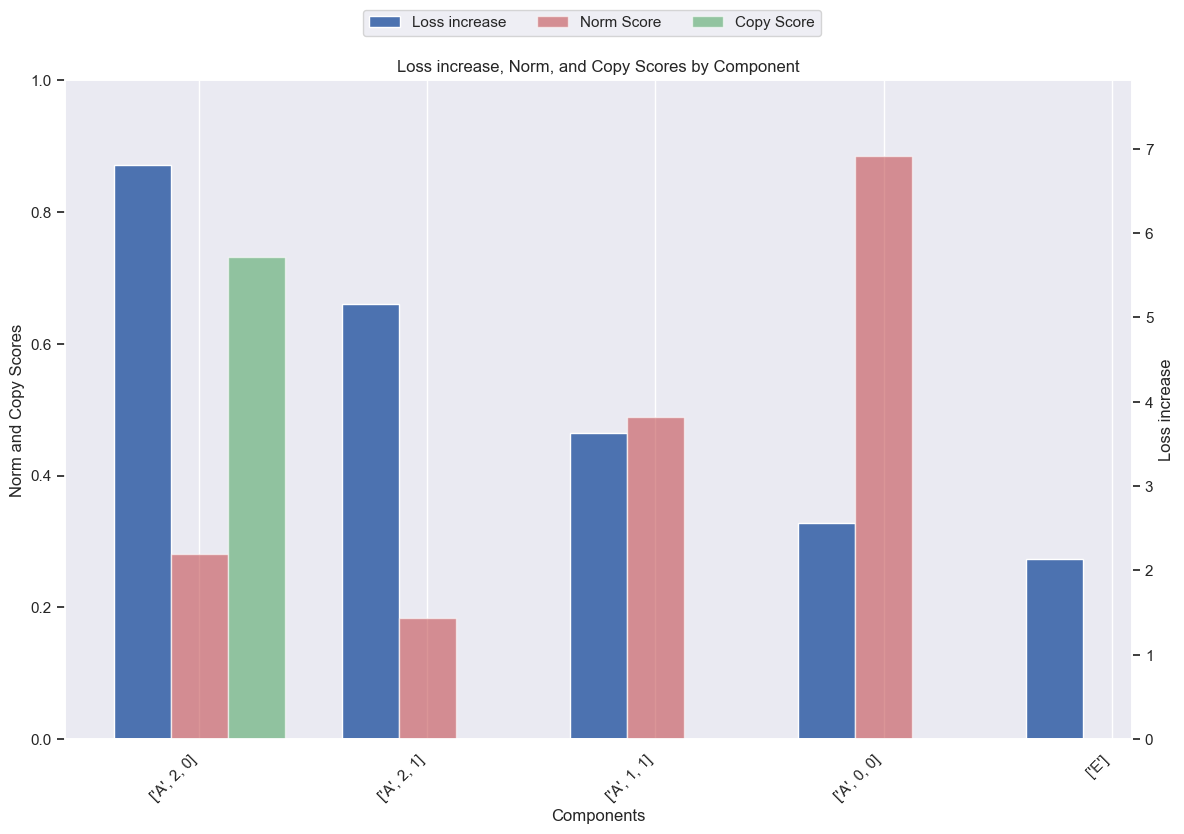

In [54]:
df_top = df_sorted.nlargest(5, 'Loss increase')

fig, ax1 = plt.subplots(figsize=(12, 8))

# Secondary axis for Norm and Copy Scores
ax2 = ax1.twinx()

# Adjust the secondary axis (ax2) to be on the left and primary (ax1) on the right
ax1.yaxis.tick_right()
ax2.yaxis.tick_left()
ax1.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

# Configuring the bar widths and positions
bar_width = 0.25
indices = np.arange(len(df_top['Removed Component']))

# Plot Increase in Performance on the primary axis
inc_perf_bars = ax1.bar(indices - bar_width, df_top['Loss increase'], bar_width, label='Loss increase', color='b')

# Plot Norm and Copy Scores on the secondary axis
norm_score_bars = ax2.bar(indices, df_top['Norm Score'], bar_width, label='Norm Score', color='r', alpha=0.6)
copy_score_bars = ax2.bar(indices + bar_width, df_top['Copy Score'], bar_width, label='Copy Score', color='g', alpha=0.6)

# Set labels and titles
ax1.set_xlabel('Components')
ax1.set_ylabel('Loss increase')
ax2.set_ylabel('Norm and Copy Scores')

ax1.grid(which='both', axis='y')
ax2.grid(which='both', axis='y')
# Adjust the range of the secondary y-axis to make the top of Norm and Copy scores align with the top of the graph
ax2.set_ylim(0, 1)

# Adjust the primary y-axis range if necessary (e.g., to make it more visually comparable)
ax1.set_ylim(0, df_top['Loss increase'].max() + 1)  # Adjust as necessary

ax1.set_title('Loss increase, Norm, and Copy Scores by Component')
ax1.set_xticks(indices)
ax1.set_xticklabels([str(item) for item in df_top['Removed Component']], rotation=45, ha="right")

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

plt.tight_layout()
plt.show()


In [61]:
df_sorted.to_csv('increased_loss_from_ablating_components.csv')